### Dara preparation 1: Burn the rasters
The first step is burn the building information into the rasters and create an image copy of original raster (.png), a building label file (.npy), and a mask file (.png). It will take ~4 hours to finish the burning process.

In [4]:
%matplotlib inline

import os, sys, shutil, tempfile
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors

import imageio
import cv2
import skimage
from skimage import transform
from skimage import io

import rasterio
from rasterio import features, mask
from rasterio.features import rasterize
import fiona

import imgaug.augmenters as iaa

# from tools.util import *
from mask_rcnn_utils import*

from tqdm import tqdm
from natsort import natsorted

import time
from PIL import Image

import random
from glob import glob

In [2]:
"""
Global variables for step one
"""
data_root = "/mnt/ceph/boyuz/Builiding_Landscaping/building_dataset"
target_root = join(data_root, "raster_images_with_label")

# mode
TESTING = False
GOOGLE, BING, OSM = True, True, True

In [15]:
# # this cell debug the overlapping prbolem
# rasters_path = "/mnt/ceph/boyuz/Builiding_Landscaping/building_dataset/Google_Raster_Images/Badala.tif"
# shps = fiona.open(join(data_root, "Shapefiles/Google_Building_Features.shp"), "r")

# with rasterio.open(rasters_path) as src:
#     ras_meta = src.profile
#     org_data = src.read()
#     img_shape = src.shape
#     transform = src.transform
# image_data = org_data.copy()

# print('Processing '+ rasters_path)

# label_image = np.zeros((1, img_shape[0], img_shape[1]))

# modern_counter, tradition_counter,  instance_counter = 0, 0, 0
# instance_labels = []
# # loop all geoms
# geoms = [feature["geometry"] for feature in shps]
# geom_labels = [feature['properties']['Type'] for feature in shps]

# overlap_detection = np.zeros([1, img_shape[0], img_shape[1]])

# for geom, bldg_type in zip(geoms, geom_labels):
#     # generate mask for current object
#     out_mask = features.rasterize([geom], out_shape = img_shape, transform = transform)
#     # contains instances
#     if np.max(out_mask) == 1:
#         # modern ->1
#         if bldg_type == 'modern':
#             label_image[:,out_mask==1] = instance_counter + 1
#             instance_labels.append(1)
#             instance_counter += 1
#             modern_counter += 1
#         # traditional -> 2
#         elif bldg_type == 'trad':
#             label_image[:,out_mask==1] = instance_counter + 1
#             instance_labels.append(2)
#             instance_counter += 1
#             tradition_counter += 1   
#         # if building type is not 'modern' or 'trad' raise an error and stop
#         else:
#             print(bldg_type)
#             raise ValueError('building type not supported')
#         # if instance_counter == 39:
#         #     print('error here')
#         # print('current counters: ', instance_counter, modern_counter, tradition_counter)
#         # print(len(np.unique(label_image)))
#         overlap_detection = np.add(overlap_detection, out_mask)

# print(np.max(np.sum(overlap_detection, axis=0)))

# # imageio.imwrite(join(target_root, raster_name[:-4] + '_image.png'), np.moveaxis(image_data, 0, -1)[:, :, 0:3])
# # np.save(join(target_root, raster_name[:-4] + '_mask.npy'), label_image)
# # np.save(join(target_root, raster_name[:-4] + '_label.npy'), instance_labels)
# # print('Finished ' + raster_name,          
# #         '\n Number of modern buildings: ', modern_counter, 
# #         '\n Number of traditional buildings: ', tradition_counter)


Processing /mnt/ceph/boyuz/Builiding_Landscaping/building_dataset/Google_Raster_Images/Badala.tif
2.0


Burn Google rasters.

In [4]:
if GOOGLE:
    rasters_path = join(data_root, "Google_Raster_Images")
    shps = fiona.open(join(data_root, "Shapefiles/Google_Building_Features.shp"), "r")

    img_list = os.listdir(rasters_path) 

    for index, raster_name in enumerate(img_list):
        # open raster file
        with rasterio.open(join(rasters_path, raster_name)) as src:
            ras_meta = src.profile
            org_data = src.read()
            img_shape = src.shape
            transform = src.transform
        image_data = org_data.copy()

        print('Processing '+ raster_name)

        label_image = np.zeros((1, img_shape[0], img_shape[1]))

        modern_counter, tradition_counter,  instance_counter = 0, 0, 0
        instance_labels = []
        # loop all geoms
        geoms = [feature["geometry"] for feature in shps]
        geom_labels = [feature['properties']['Type'] for feature in shps]

        for geom, bldg_type in tqdm(zip(geoms, geom_labels)):
            # generate mask for current object
            out_mask = features.rasterize([geom], out_shape = img_shape, transform = transform)
            # contains instances
            if np.max(out_mask) == 1:
                # modern ->1
                if bldg_type == 'modern':
                    label_image[:,out_mask==1] = instance_counter + 1
                    instance_labels.append(1)
                    instance_counter += 1
                    modern_counter += 1
                # traditional -> 2
                elif bldg_type == 'trad':
                    label_image[:,out_mask==1] = instance_counter + 1
                    instance_labels.append(2)
                    instance_counter += 1
                    tradition_counter += 1   
                # if building type is not 'modern' or 'trad' raise an error and stop
                else:
                    print(bldg_type)
                    raise ValueError('building type not supported')
        
        imageio.imwrite(join(target_root, raster_name[:-4] + '_image.png'), np.moveaxis(image_data, 0, -1)[:, :, 0:3])
        np.save(join(target_root, raster_name[:-4] + '_mask.npy'), label_image)
        np.save(join(target_root, raster_name[:-4] + '_label.npy'), instance_labels)
        print('Finished ' + raster_name,          
              '\n Number of modern buildings: ', modern_counter, 
              '\n Number of traditional buildings: ', tradition_counter)
              
        if TESTING:
            break

Processing Makuna.tif


8407it [01:23, 100.51it/s]


Finished Makuna.tif 
 Number of modern buildings:  37 
 Number of traditional buildings:  3
Processing Badala.tif


8407it [06:16, 22.36it/s]


Finished Badala.tif 
 Number of modern buildings:  240 
 Number of traditional buildings:  7
Processing Kanipo.tif


8407it [00:45, 183.07it/s]


Finished Kanipo.tif 
 Number of modern buildings:  32 
 Number of traditional buildings:  0
Processing Jimmy.tif


8407it [12:57, 10.82it/s]


Finished Jimmy.tif 
 Number of modern buildings:  369 
 Number of traditional buildings:  6
Processing Gbetaya_3.tif


8407it [09:49, 14.25it/s]


Finished Gbetaya_3.tif 
 Number of modern buildings:  284 
 Number of traditional buildings:  816
Processing Bafodia.tif


8407it [15:45,  8.89it/s]


Finished Bafodia.tif 
 Number of modern buildings:  305 
 Number of traditional buildings:  0
Processing Chembu.tif


8407it [02:59, 46.92it/s]


Finished Chembu.tif 
 Number of modern buildings:  60 
 Number of traditional buildings:  27
Processing Barlie.tif


8407it [01:03, 131.73it/s]


Finished Barlie.tif 
 Number of modern buildings:  110 
 Number of traditional buildings:  0
Processing Makump.tif


8407it [13:35, 10.31it/s]


Finished Makump.tif 
 Number of modern buildings:  231 
 Number of traditional buildings:  2
Processing Gbetaya_2.tif


8407it [01:33, 89.81it/s]


Finished Gbetaya_2.tif 
 Number of modern buildings:  27 
 Number of traditional buildings:  186
Processing Ngegbeima.tif


8407it [08:51, 15.82it/s]


Finished Ngegbeima.tif 
 Number of modern buildings:  344 
 Number of traditional buildings:  0
Processing Gbetaya.tif


8407it [02:01, 69.28it/s]


Finished Gbetaya.tif 
 Number of modern buildings:  87 
 Number of traditional buildings:  223
Processing Benduma.tif


8407it [00:40, 206.13it/s]


Finished Benduma.tif 
 Number of modern buildings:  100 
 Number of traditional buildings:  1
Processing Njaguima.tif


8407it [00:19, 435.88it/s]


Finished Njaguima.tif 
 Number of modern buildings:  28 
 Number of traditional buildings:  0
Processing Kobadu.tif


8407it [01:06, 126.28it/s]


Finished Kobadu.tif 
 Number of modern buildings:  71 
 Number of traditional buildings:  0
Processing Ngaiagoehun.tif


8407it [01:01, 137.07it/s]


Finished Ngaiagoehun.tif 
 Number of modern buildings:  64 
 Number of traditional buildings:  2
Processing Gbenikoro.tif


8407it [07:48, 17.94it/s]


Finished Gbenikoro.tif 
 Number of modern buildings:  121 
 Number of traditional buildings:  1
Processing Tanganya.tif


8407it [04:11, 33.37it/s]


Finished Tanganya.tif 
 Number of modern buildings:  98 
 Number of traditional buildings:  274
Processing Malambay.tif


8407it [29:10,  4.80it/s]


Finished Malambay.tif 
 Number of modern buildings:  241 
 Number of traditional buildings:  21
Processing North_Tanganya.tif


8407it [06:47, 20.65it/s]


Finished North_Tanganya.tif 
 Number of modern buildings:  112 
 Number of traditional buildings:  200
Processing Guala.tif


8407it [01:35, 88.10it/s]


Finished Guala.tif 
 Number of modern buildings:  128 
 Number of traditional buildings:  0
Processing West_Bantou_1.tif


8407it [01:00, 138.15it/s]


Finished West_Bantou_1.tif 
 Number of modern buildings:  60 
 Number of traditional buildings:  368
Processing Largo.tif


8407it [15:37,  8.97it/s]


Finished Largo.tif 
 Number of modern buildings:  552 
 Number of traditional buildings:  11
Processing Gbetaya_1.tif


8407it [01:17, 109.07it/s]


Finished Gbetaya_1.tif 
 Number of modern buildings:  39 
 Number of traditional buildings:  140
Processing Mid_Tanganya_Bantou.tif


8407it [03:42, 37.75it/s]


Finished Mid_Tanganya_Bantou.tif 
 Number of modern buildings:  182 
 Number of traditional buildings:  406
Processing Kapethe.tif


8407it [02:06, 66.72it/s]


Finished Kapethe.tif 
 Number of modern buildings:  92 
 Number of traditional buildings:  0
Processing Talama.tif


8407it [40:28,  3.46it/s]


Finished Talama.tif 
 Number of modern buildings:  685 
 Number of traditional buildings:  0
Processing Bantou.tif


8407it [07:32, 18.57it/s]


Finished Bantou.tif 
 Number of modern buildings:  125 
 Number of traditional buildings:  821
Processing Taima.tif


8407it [02:36, 53.62it/s]


Finished Taima.tif 
 Number of modern buildings:  61 
 Number of traditional buildings:  1


Burn Bing rasters.

In [6]:
if BING:
    rasters_path = join(data_root, "Bing_Raster_Images")
    img_list = ['BHR_Gbetaya.tif', 'BHR_Guala_Cloud_1.tif', 'BHR_Guala_Cloud_2.tif', 'BHR_Guala_Cloud_3.tif', 
                 'BHR_Guala_Cloud_4.tif', 'BHR_Malambay_Cloud_1.tif']
    shps = fiona.open(join(data_root, "Shapefiles/Bing_Building_Features.shp"), "r")

    for index, raster_name in enumerate(img_list):
        # open raster file
        with rasterio.open(join(rasters_path, raster_name)) as src:
            ras_meta = src.profile
            org_data = src.read()
            img_shape = src.shape
            transform = src.transform
        image_data = org_data.copy()

        print('Processing '+ raster_name)

        label_image = np.zeros((1, img_shape[0], img_shape[1]))

        modern_counter, tradition_counter,  instance_counter = 0, 0, 0
        instance_labels = []
        # loop all geoms
        geoms = [feature["geometry"] for feature in shps]
        geom_labels = [feature['properties']['Type'] for feature in shps]

        for geom, bldg_type in tqdm(zip(geoms, geom_labels)):
            # generate mask for current object
            out_mask = features.rasterize([geom], out_shape = img_shape, transform = transform)
            # contains instances
            if np.max(out_mask) == 1:
                # modern ->1
                if bldg_type == 'modern':
                    label_image[:,out_mask==1] = instance_counter + 1
                    instance_labels.append(1)
                    instance_counter += 1
                    modern_counter += 1
                # traditional -> 2
                elif bldg_type == 'trad':
                    label_image[:,out_mask==1] = instance_counter + 1
                    instance_labels.append(2)
                    instance_counter += 1
                    tradition_counter += 1   
                # if building type is not 'modern' or 'trad' raise an error and stop
                else:
                    print(bldg_type)
                    raise ValueError('building type not supported')
        
        imageio.imwrite(join(target_root, raster_name[:-4] + '_image.png'), np.moveaxis(image_data, 0, -1)[:, :, 0:3])
        np.save(join(target_root, raster_name[:-4] + '_mask.npy'), label_image)
        np.save(join(target_root, raster_name[:-4] + '_label.npy'), instance_labels)
        print('Finished ' + raster_name,
              '\n Number of modern buildings: ', modern_counter, 
              '\n Number of traditional buildings: ', tradition_counter)
        
        if TESTING:
            break

Processing BHR_Gbetaya.tif


356it [00:39,  9.08it/s]


Finished BHR_Gbetaya.tif 
 Number of modern buildings:  73 
 Number of traditional buildings:  250
Processing BHR_Guala_Cloud_1.tif


356it [00:26, 13.64it/s]


Finished BHR_Guala_Cloud_1.tif 
 Number of modern buildings:  0 
 Number of traditional buildings:  0
Processing BHR_Guala_Cloud_2.tif


356it [00:17, 20.91it/s]


Finished BHR_Guala_Cloud_2.tif 
 Number of modern buildings:  0 
 Number of traditional buildings:  0
Processing BHR_Guala_Cloud_3.tif


356it [00:09, 38.18it/s]


Finished BHR_Guala_Cloud_3.tif 
 Number of modern buildings:  0 
 Number of traditional buildings:  0
Processing BHR_Guala_Cloud_4.tif


356it [01:48,  3.27it/s]


Finished BHR_Guala_Cloud_4.tif 
 Number of modern buildings:  31 
 Number of traditional buildings:  2
Processing BHR_Malambay_Cloud_1.tif


356it [00:09, 38.95it/s]


Finished BHR_Malambay_Cloud_1.tif 
 Number of modern buildings:  0 
 Number of traditional buildings:  0


Burn OSM raster.
Notes for OSM rasters:
1. OSM raster has seperate shape files for each raster
2. The property type field in OSM is different: 'yes'->'modern, 'hut'->'trad', there is another type 'construction' that should be ignored at this stage. 

In [8]:
if OSM:
    rasters_path = join(data_root, "Bing_Raster_Images")
    img_list = ['Bantou', 'Tanganya', 'North_Tanganya', 'Gbetaya_1', 'Gbetaya_2', 'Gbetaya_3', 
                'West_Bantou_1', 'West_Bantou_2', 'West_Bantou_3']

    for index, raster_name in enumerate(img_list):
        # open raster file
        with rasterio.open(join(rasters_path, 'BHR_' + raster_name + '.tif')) as src:
            ras_meta = src.profile
            org_data = src.read()
            img_shape = src.shape
            transform = src.transform
        image_data = org_data.copy()
        
        shps = fiona.open(join(data_root, "Shapefiles/Bing_OSM_" + raster_name + ".shp"), "r")
        
        print('Processing '+ raster_name)

        label_image = np.zeros((1, img_shape[0], img_shape[1]))

        modern_counter, tradition_counter,  instance_counter, construction_counter = 0, 0, 0, 0
        instance_labels = []
        # loop all geoms
        geoms = [feature["geometry"] for feature in shps]
        geom_labels = [feature['properties']['building'] for feature in shps]

        for geom, bldg_type in tqdm(zip(geoms, geom_labels)):
            # generate mask for current object
            out_mask = features.rasterize([geom], out_shape = img_shape, transform = transform)
            # contains instances
            if np.max(out_mask) == 1:
                # modern ->1
                if bldg_type == 'yes':
                    label_image[:,out_mask==1] = instance_counter + 1
                    instance_labels.append(1)
                    instance_counter += 1
                    modern_counter += 1
                # traditional -> 2
                elif bldg_type == 'hut':
                    label_image[:,out_mask==1] = instance_counter + 1
                    instance_labels.append(2)
                    instance_counter += 1
                    tradition_counter += 1   
                # if building type is not 'modern' or 'trad' raise an error and stop
                elif bldg_type == 'construction':
                    construction_counter += 1
                else:
                    print(bldg_type)
                    raise ValueError('building type not supported')
        
        imageio.imwrite(join(target_root, 'OSM_' + raster_name + '_image.png'), np.moveaxis(image_data, 0, -1)[:, :, 0:3])
        np.save(join(target_root, 'OSM_' + raster_name + '_mask.npy'), label_image)
        np.save(join(target_root, 'OSM_' + raster_name + '_label.npy'), instance_labels)
        print('Finished ' + raster_name,
              '\n Number of modern buildings: ', modern_counter, 
              '\n Number of traditional buildings: ', tradition_counter,
              '\n Number of construction buildings: ', construction_counter)
        
        if TESTING:
            break
    

Processing Bantou


833it [01:41,  8.21it/s]


Finished Bantou 
 Number of modern buildings:  72 
 Number of traditional buildings:  761 
 Number of construction buildings:  0
Processing Tanganya


425it [00:48,  8.82it/s]


Finished Tanganya 
 Number of modern buildings:  65 
 Number of traditional buildings:  360 
 Number of construction buildings:  0
Processing North_Tanganya


383it [00:48,  7.95it/s]


Finished North_Tanganya 
 Number of modern buildings:  116 
 Number of traditional buildings:  263 
 Number of construction buildings:  4
Processing Gbetaya_1


178it [00:05, 33.14it/s]


Finished Gbetaya_1 
 Number of modern buildings:  20 
 Number of traditional buildings:  158 
 Number of construction buildings:  0
Processing Gbetaya_2


205it [00:07, 27.58it/s]


Finished Gbetaya_2 
 Number of modern buildings:  15 
 Number of traditional buildings:  190 
 Number of construction buildings:  0
Processing Gbetaya_3


1061it [03:06,  5.68it/s]


Finished Gbetaya_3 
 Number of modern buildings:  243 
 Number of traditional buildings:  818 
 Number of construction buildings:  0
Processing West_Bantou_1


406it [00:15, 26.60it/s]


Finished West_Bantou_1 
 Number of modern buildings:  42 
 Number of traditional buildings:  364 
 Number of construction buildings:  0
Processing West_Bantou_2


640it [03:03,  3.49it/s]


Finished West_Bantou_2 
 Number of modern buildings:  138 
 Number of traditional buildings:  502 
 Number of construction buildings:  0
Processing West_Bantou_3


459it [00:16, 28.14it/s]


Finished West_Bantou_3 
 Number of modern buildings:  39 
 Number of traditional buildings:  417 
 Number of construction buildings:  0


#### Data preparation 2: split image/label/mask

split the raster, label, and mask image into tiles with specific size. The reason is that the Mask R-CNN couldn't handle that much targets all together.

In [5]:
"""
Global variables for step 2
"""
TESTING = True
tile_shape = np.array([1024, 1024]).astype(int)
stride = np.round(tile_shape/2).astype(int)

raster_dir_1 = "/mnt/ceph/boyuz/Builiding_Landscaping/building_dataset/raster_images_with_label"
"/mnt/ceph/boyuz/BU_Classifier/MRCNN/color_transformed"
raster_dir_2 = "/mnt/ceph/boyuz/BU_Classifier/MRCNN/color_transformed"
target_root = "/mnt/ceph/boyuz/Builiding_Landscaping/building_dataset/tiles_1024/"

In [3]:
# Functions for step 2
def save_tile(tile_image, tile_mask, tile_label, target_dataset_folder, image_path, tile_index):
    parent_image_name = image_path.split('/')[-1]
    
    tile_image_name = target_dataset_folder + \
                      parent_image_name.replace('_image.png', '_tile_') + \
                      str(tile_index) + '_image.png'
    imageio.imwrite(tile_image_name, tile_image)

    mask_file_name = tile_image_name.replace('_image.png', '_mask.npy')
    np.save(mask_file_name, tile_mask)

    label_file_name = tile_image_name.replace('_image.png', '_label.npy')
    np.save(label_file_name, tile_label)

    return True

# map the original instance id to 1~n, where n is the number of instance.
def reassign_instance_index(raw_mask):
    index_list = natsorted(np.unique(raw_mask)[1:])
    new_mask = np.zeros_like(raw_mask)
    # loop over instances
    instance_counter = 0
    for index in index_list:
        new_mask[raw_mask==index] = instance_counter + 1
        instance_counter += 1
    return new_mask


# remove the instances that are too small, or too narrow
def instance_filter(raw_mask, raw_labels, min_area= 64, min_ratio=0.1, max_ratio=10):
    # return false if instances and labels don't match
    if len(np.unique(raw_mask)) != len(raw_labels) + 1:
        return False, raw_mask, raw_labels
    
    # create a new mask that include 
    new_mask = reassign_instance_index(raw_mask)
    # create seperate mask for each instance
    obj_ids = np.unique(new_mask)[1:]
    num_objs = len(obj_ids)
    masks_objs = new_mask==obj_ids[:, None, None]
    
    new_label = []
    for i in range(num_objs):
        pos = np.where(masks_objs[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])    
        area = (xmax - xmin) * (ymax - ymin)
        ratio = (xmax - xmin + 1)/(ymax - ymin + 1)
        '''
        if the area is too small or width/height too small or too small. 
        There are some partially presented instances left.
        '''
        if (abs(xmax-xmin)<5) or (abs(ymax-ymin)<5) or \
            (area<=min_area) or (ratio>=max_ratio) or (ratio<=min_ratio):
            new_mask[new_mask==obj_ids[i]] = 0
        else:
            new_label.append(raw_labels[i])
    
    if len(new_label) > 0:
        # if some instances were removed, reassian instance id
        if len(new_label) != len(raw_labels):
            new_mask = reassign_instance_index(new_mask)
        return True, new_mask, new_label
    else:
        return False, raw_mask, raw_labels

In [7]:
# split image and save
raster_list_1 = glob(join(raster_dir_1, '*_image.png'))
raster_list_2 = glob(join(raster_dir_2, '*_image.png'))
raster_list = raster_list_2 + raster_list_1
print(len(raster_list))

for raster in raster_list:
    _, img, mask, label = read_burned_raster(raster)
    print(raster.split('/')[-1], ' Image size: ', img.shape, mask.shape)

    # prepare for spliting
    im_h, im_w = mask.shape
    bl_h, bl_w = stride
    tile_counter = 0

    for row in np.arange(im_h - bl_h + 1, step=bl_h):
        for col in np.arange(im_w - bl_w + 1, step=bl_w):
            # get tile for image and mask
            tile_img = img[row:row+bl_h, col:col+bl_w, :]
            tile_msk = mask[row:row+bl_h, col:col+bl_w]
            '''
            This is tricky. Need to drop the zero. Besides, the instance index is 1 based, but the labels are 0 based. 
            '''
            ids = [int(x-1) for x in np.unique(tile_msk)[1:]]
            tile_lbl = label[ids]
            # only keep tiles with instances

            if len(tile_lbl) == 0:
                continue
            else:
                flag, tile_msk, tile_lbl = instance_filter(tile_msk, tile_lbl)
            
            if flag:
                save_tile(tile_img, tile_msk, tile_lbl, target_root, raster, tile_counter)
                tile_counter += 1
        

64
Barlie_trans_image.png  Image size:  (1603, 2952, 3) (1603, 2952)
Guala_trans_image.png  Image size:  (3211, 2190, 3) (3211, 2190)
Bafodia_trans_image.png  Image size:  (6700, 6500, 3) (6700, 6500)
Taima_trans_image.png  Image size:  (2930, 3453, 3) (2930, 3453)
Kobadu_trans_image.png  Image size:  (2506, 2027, 3) (2506, 2027)
Kapethe_trans_image.png  Image size:  (2163, 3983, 3) (2163, 3983)
Ngegbeima_trans_image.png  Image size:  (5000, 5500, 3) (5000, 5500)
Gbetaya_trans_image.png  Image size:  (3371, 2500, 3) (3371, 2500)
Njaguima_trans_image.png  Image size:  (793, 1461, 3) (793, 1461)
Malambay_trans_image.png  Image size:  (7809, 11285, 3) (7809, 11285)
Largo_trans_image.png  Image size:  (10000, 4325, 3) (10000, 4325)
Kanipo_trans_image.png  Image size:  (1250, 2302, 3) (1250, 2302)
Makuna_trans_image.png  Image size:  (1667, 3069, 3) (1667, 3069)
Benduma_trans_image.png  Image size:  (1250, 2302, 3) (1250, 2302)


/mnt/ceph/boyuz/miniconda3/envs/gis/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (117274500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Talama_trans_image.png  Image size:  (10710, 10950, 3) (10710, 10950)
Jimmy_trans_image.png  Image size:  (6742, 5180, 3) (6742, 5180)
Ngaiagoehun_trans_image.png  Image size:  (1594, 2936, 3) (1594, 2936)
Bantou_trans_image.png  Image size:  (3465, 6381, 3) (3465, 6381)
Gbenikoro_trans_image.png  Image size:  (3706, 6825, 3) (3706, 6825)
Chembu_trans_image.png  Image size:  (2500, 4604, 3) (2500, 4604)
Tanganya_trans_image.png  Image size:  (3371, 4506, 3) (3371, 4506)
Makump_trans_image.png  Image size:  (6475, 6175, 3) (6475, 6175)
Kobadu_image.png  Image size:  (2506, 2027, 3) (2506, 2027)
BHR_Guala_Cloud_1_image.png  Image size:  (4824, 6619, 3) (4824, 6619)
OSM_West_Bantou_2_image.png  Image size:  (5458, 11071, 3) (5458, 11071)
Talama_image.png  Image size:  (10710, 10950, 3) (10710, 10950)
OSM_Gbetaya_1_image.png  Image size:  (1958, 3969, 3) (1958, 3969)
Gbetaya_1_image.png  Image size:  (1865, 3055, 3) (1865, 3055)
Tanganya_image.png  Image size:  (3371, 4506, 3) (3371, 4506)

/mnt/ceph/boyuz/miniconda3/envs/gis/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (120650840 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


BHR_Guala_Cloud_4_image.png  Image size:  (10616, 11365, 3) (10616, 11365)
Gbenikoro_image.png  Image size:  (3706, 6825, 3) (3706, 6825)
Ngaiagoehun_image.png  Image size:  (1594, 2936, 3) (1594, 2936)
Njaguima_image.png  Image size:  (793, 1461, 3) (793, 1461)
OSM_North_Tanganya_image.png  Image size:  (3717, 7539, 3) (3717, 7539)
Largo_image.png  Image size:  (10000, 4325, 3) (10000, 4325)
Makump_image.png  Image size:  (6475, 6175, 3) (6475, 6175)
Mid_Tanganya_Bantou_image.png  Image size:  (3380, 3916, 3) (3380, 3916)
Bafodia_image.png  Image size:  (6700, 6500, 3) (6700, 6500)


Test: randomly a tile and the corresponding mask, print the class labels.

[1 1 1 1 1 1 1 1]


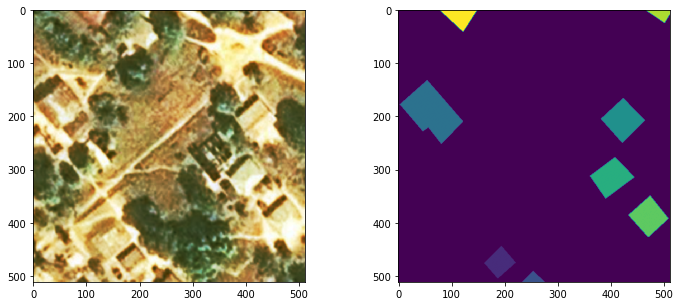

In [10]:
tile_list = glob(join('/mnt/ceph/boyuz/Builiding_Landscaping/building_dataset/tiles_1024', '*_image.png'))

img_path = random.choice(tile_list)
_, img, mask, label = read_burned_raster(img_path)

print(label)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(img)
ax2.imshow(mask)